In [4]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.utils import data
import seaborn as sn
import pandas as pd
from tqdm import tqdm
plt.ion()   # interactive mode

In [5]:
folder_path = 'augmentation/Campbell_Keister_Trainingset_Augmented_Dataset/'

In [6]:
model_name = folder_path.replace("/", "")

In [ ]:
dataset = datasets.ImageFolder(folder_path, transform=transforms.Compose(
                            [transforms.Resize(256),
                             transforms.CenterCrop(224),
                             transforms.ToTensor()]))

loader = data.DataLoader(dataset,
                         batch_size=10,
                         num_workers=0,
                         shuffle=False)

mean = 0.0
for images, _ in loader:
    batch_samples = images.size(0) 
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
mean = mean / len(loader.dataset)

var = 0.0
for images, _ in loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    var += ((images - mean.unsqueeze(1))**2).sum([0,2])
std = torch.sqrt(var / (len(loader.dataset)*224*224))

In [12]:
mean,std =[[0.1195, 0.1047, 0.0819],[0.2350, 0.2075, 0.1644]]

In [20]:
# mean = np.array([0.485, 0.456, 0.406])
# std = np.array([0.229, 0.224, 0.225])

transform = transforms.Compose([
#         transforms.RandomResizedCrop(224),
#         SquarePad(),
        transforms.Resize((224,224)),
#         transforms.CenterCrop((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

images = datasets.ImageFolder(os.path.join(folder_path),transform)
data_size = len(images.imgs)
train_size = int(data_size*0.8)
val_size = (data_size-train_size)//2
test_size = data_size-train_size-val_size
train_set, val_set, test_set = data.random_split(images, (train_size,val_size,test_size))
image_datasets = {'train':train_set, 'val':val_set,'test':test_set}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val','test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}
class_names = images.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [21]:
dataset_sizes

{'train': 140982, 'val': 17623, 'test': 17623}

torch.Size([224, 224])


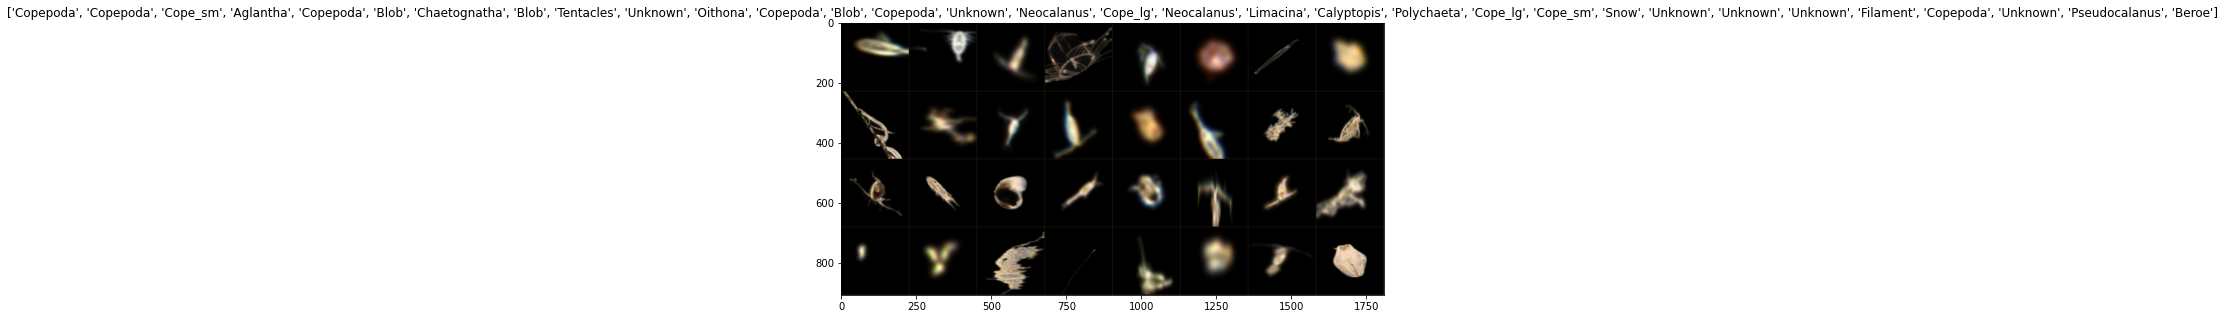

In [22]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
#     plt.pause(0.001)  # pause a bit so that plots are updated
#     plt.savefig('input samples.png')

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
print(inputs[0][0].shape)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
plt.figure(figsize=(20,5))
imshow(out, title=[class_names[x] for x in classes])
plt.savefig(model_name+'input samples.png')


In [16]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [17]:
def visualize_model(model, num_images=40):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(20,20),dpi=200)
    sm = torch.nn.Softmax()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            l=labels
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            confidence = np.amax(np.array(sm(outputs.cpu())),1)
#             break
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//4, 4, images_so_far)
                ax.axis('off')
                ax.set_title('{0}; GT: {1}; Confidence {2:.2f}'.format(class_names[preds[j]],class_names[l[j]],confidence[j]))
#                 imshow(inputs.cpu().data[j])
                inp = inputs.cpu().data[j].numpy().transpose((1, 2, 0))

                inp = std * inp + mean
                inp = np.clip(inp, 0, 1)    
                ax.imshow(inp)
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


In [23]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

In [24]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)

Epoch 0/14
----------
train Loss: 1.0103 Acc: 0.6882
val Loss: 0.6592 Acc: 0.7844

Epoch 1/14
----------
train Loss: 0.5545 Acc: 0.8157
val Loss: 0.4009 Acc: 0.8665

Epoch 2/14
----------
train Loss: 0.3227 Acc: 0.8951
val Loss: 0.2418 Acc: 0.9231

Epoch 3/14
----------
train Loss: 0.1803 Acc: 0.9436
val Loss: 0.1306 Acc: 0.9597

Epoch 4/14
----------
train Loss: 0.1020 Acc: 0.9690
val Loss: 0.0874 Acc: 0.9738

Epoch 5/14
----------
train Loss: 0.0362 Acc: 0.9919
val Loss: 0.0349 Acc: 0.9909

Epoch 6/14
----------


KeyboardInterrupt: 

C:\Users\piyalong\.conda\envs\TAMIDS2\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


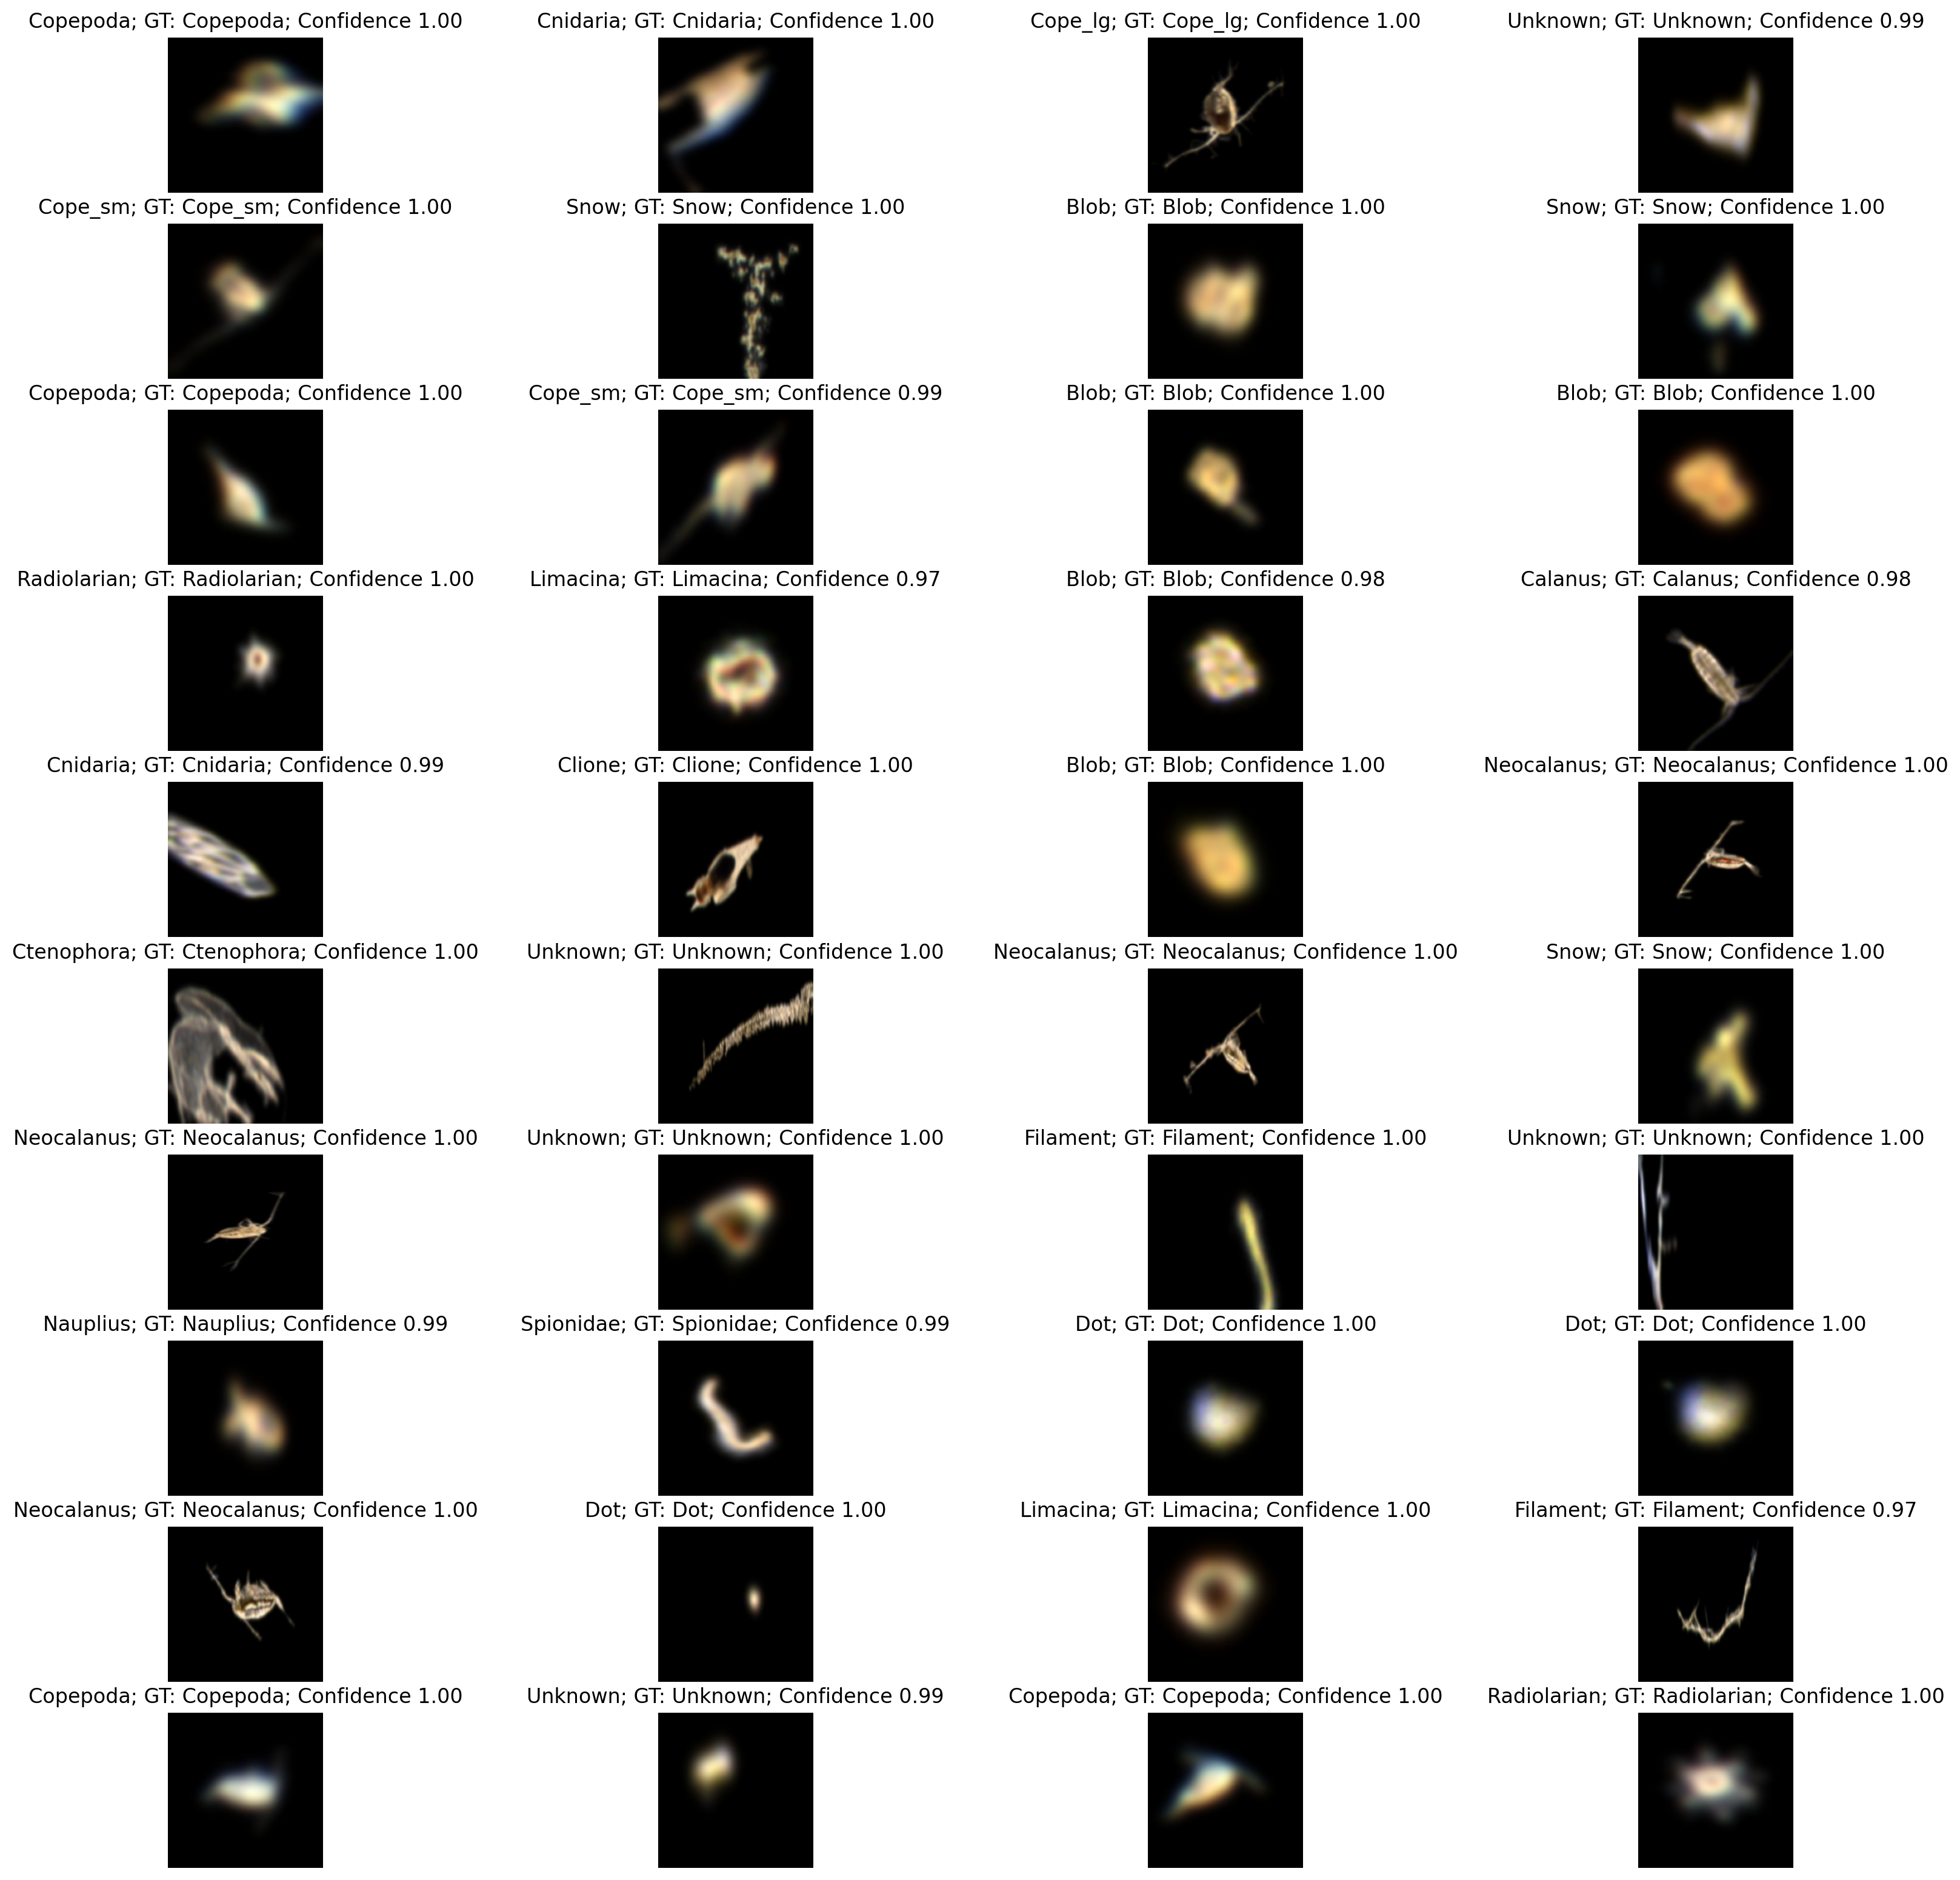

In [32]:
visualize_model(model_ft)
plt.savefig(model_name+'.png')

In [26]:
torch.save(model_ft, model_name+'.pth')

In [27]:
model_ft = torch.load(model_name+'.pth')

# ResNet result analysis

In [28]:
nb_classes = len(class_names)

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['test']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[6.3000e+01, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 9.0000e+01, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 2.4200e+02,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.0900e+02, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.0000e+00, 1.1600e+02,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         2.2450e+03]])


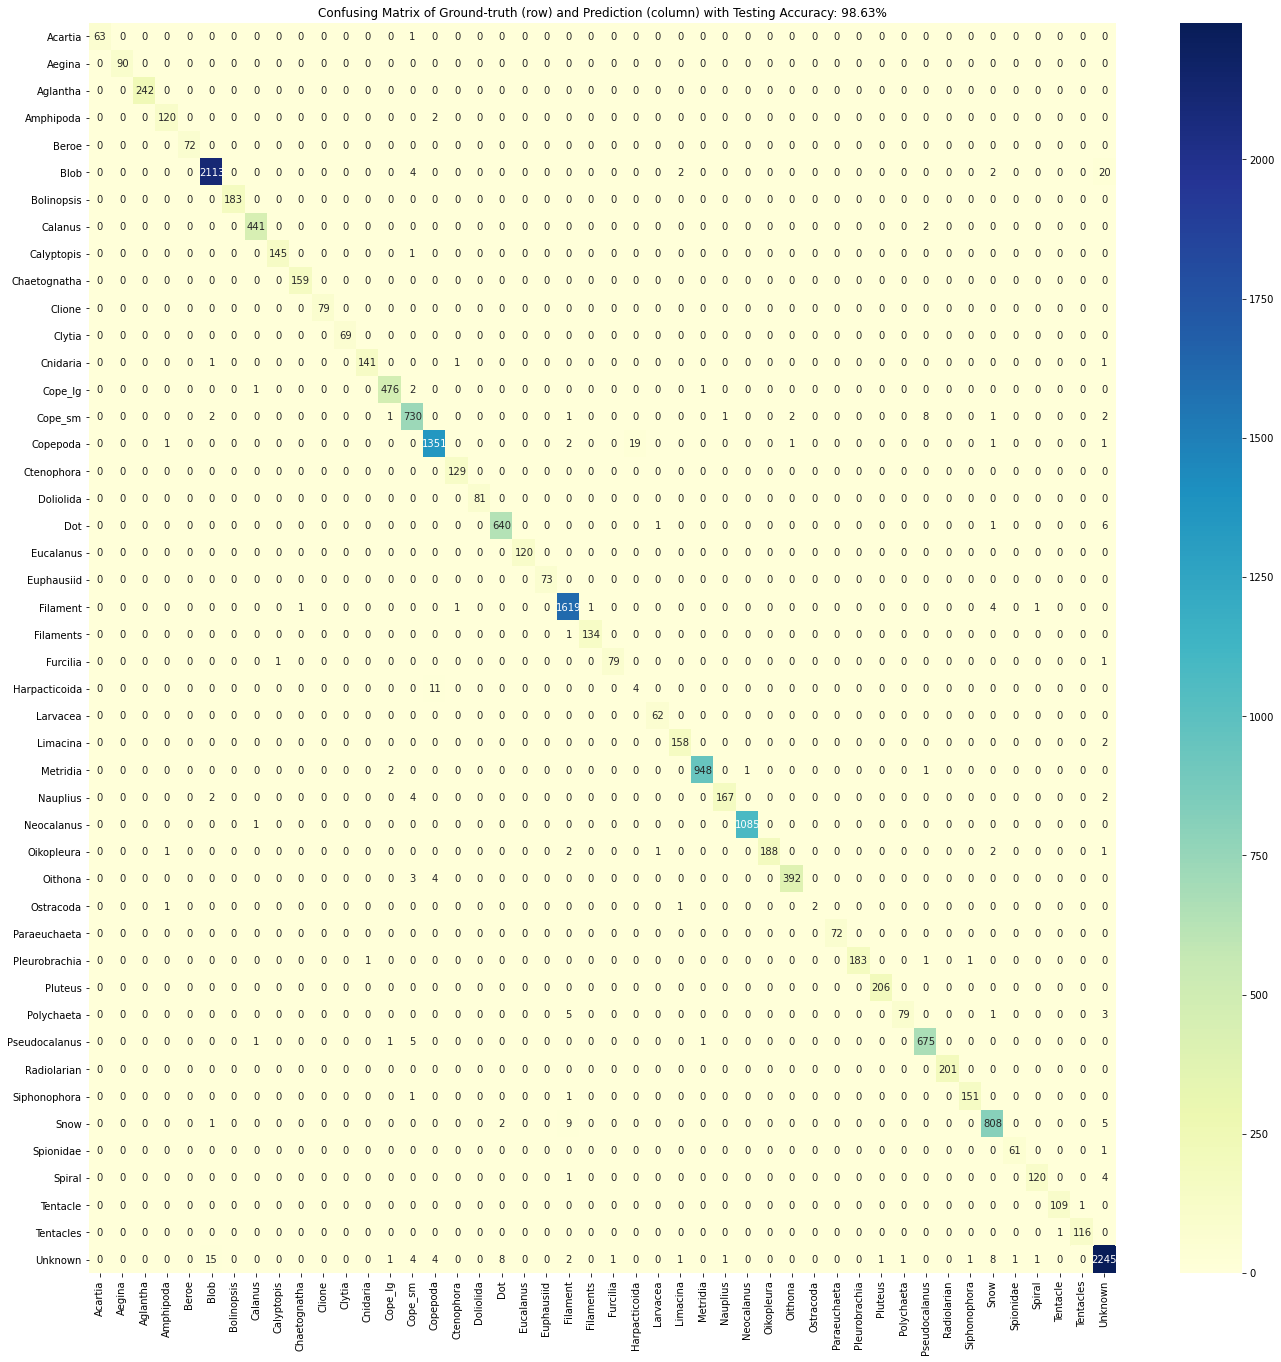

In [30]:
df_cm = pd.DataFrame(confusion_matrix.numpy().astype('int'), index = [i for i in class_names],
                  columns = [i for i in class_names])

test_acc=np.trace(confusion_matrix.numpy().astype('int'))/np.sum(np.sum(df_cm))
df_cm.to_csv(model_name+'.csv')
plt.figure(figsize = (len(class_names)//2,len(class_names)//2))
plt.title('Confusing Matrix of Ground-truth (row) and Prediction (column) with Testing Accuracy: {:0.2f}%'.format(test_acc*100))
sn.heatmap(df_cm, annot=True,fmt='g',cmap="YlGnBu")
plt.savefig(model_name+'Confusing Matrix.png')

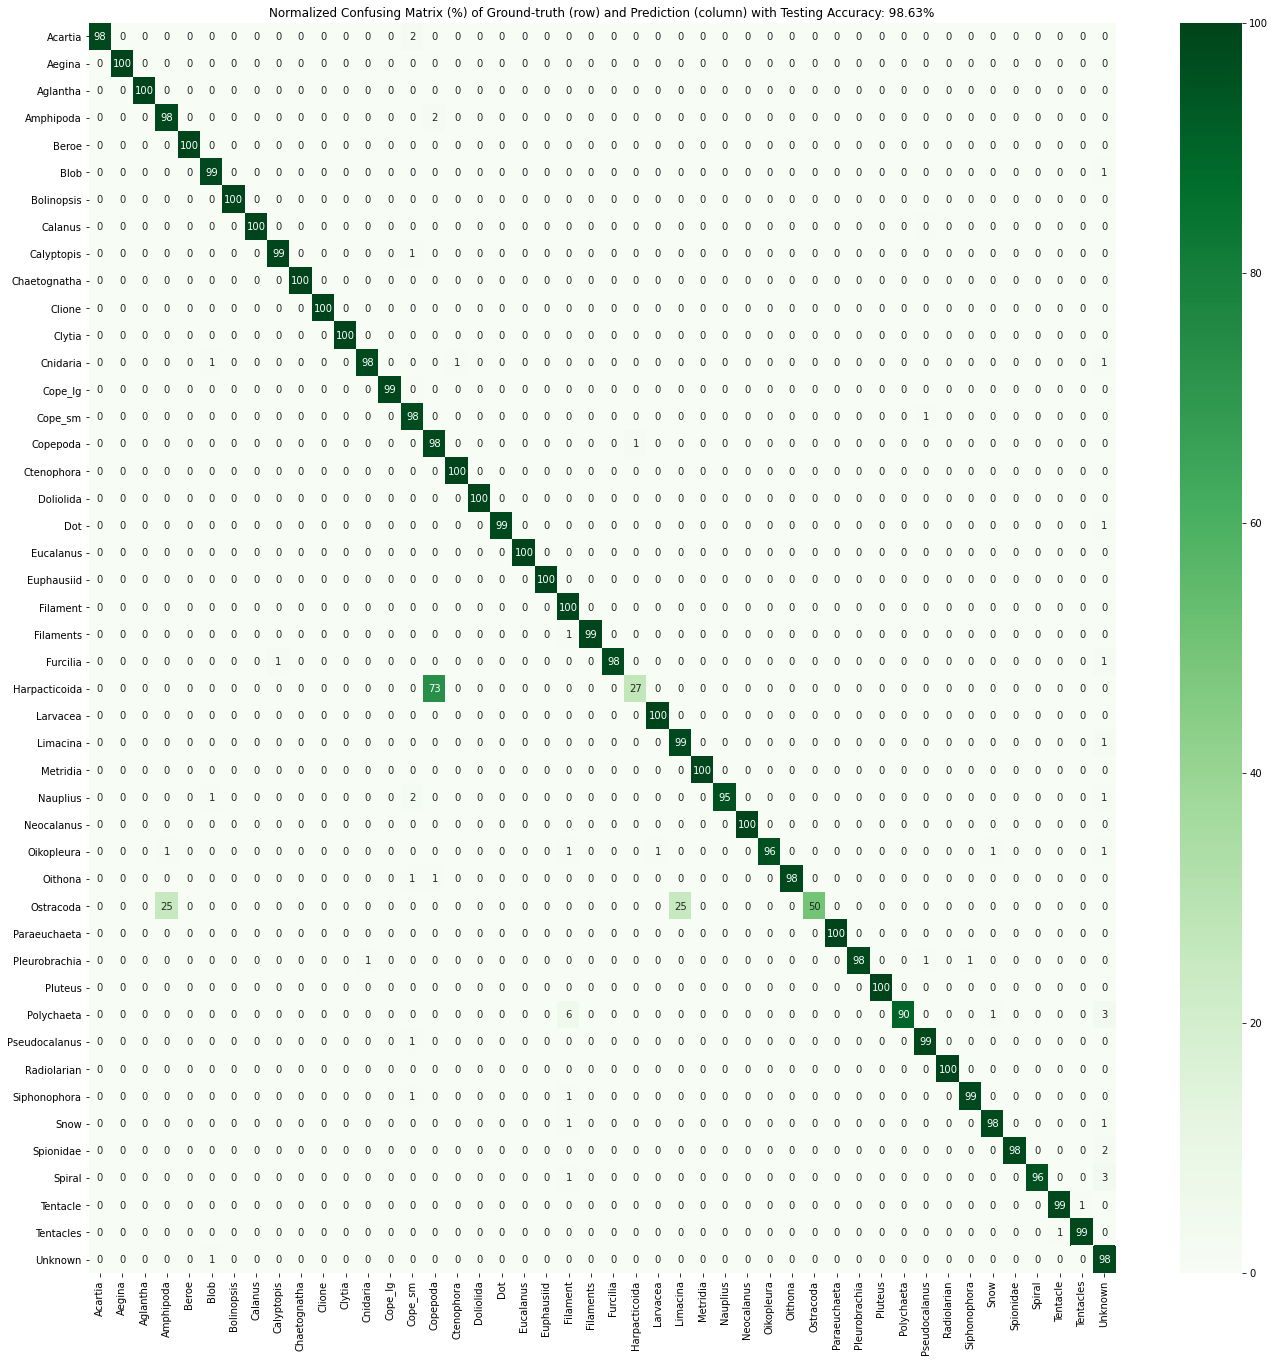

In [31]:
nor = df_cm / np.array([df_cm.sum(axis=1)]*len(class_names)).transpose()
plt.figure(figsize = (len(class_names)//2,len(class_names)//2))
plt.title('Normalized Confusing Matrix (%) of Ground-truth (row) and Prediction (column) with Testing Accuracy: {:0.2f}%'.format(test_acc*100))
sn.heatmap(nor*100, annot=True,fmt='.0f',cmap="Greens")
plt.savefig(model_name+'Confusing Matrix(%).png')